# Visualizations for RECIST vs. PyRadiomics Measurements

## Dependencies

In [84]:
import pandas as pd 
import matplotlib.pyplot as plt

from damply import dirs 
from pathlib import Path

## Load Data

In [74]:
matched_pyrad_ann_file = dirs.PROCDATA / "PMCC_OCTANE/metadata/recist_diameter_stats/matched_pyradiomics_annotations.csv"

pyrad_ann_df = pd.read_csv(matched_pyrad_ann_file)

num_ann = pyrad_ann_df.shape[0]

## Visualize Raw Data

### Setting Up Label and Save Parameters

In [87]:
num_ann = pyrad_ann_df.shape[0] #Number of tumour annotations in current cohort

pyrad_feature = "original_shape_Maximum2DDiameterSlice"
pyrad_feat_label = pyrad_feature.split("_")[-1]

dataset = "PMCC_OCTANE"

save_folder = Path("/home/bhkuser/bhklab/kaitlyn/recist-vs-reality/data/results/PMCC_OCTANE/visualization/recist_vs_pyradiomics/" + pyrad_feat_label)

if not save_folder.exists(): 
    save_folder.mkdir(parents=True, exist_ok=True)

### Scatter Plot: Pyradiomics Measurement vs. RECIST Measurement

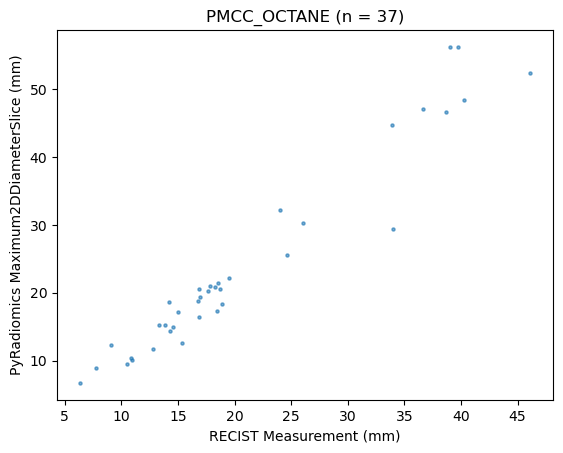

In [88]:
plt.scatter(pyrad_ann_df["AnnLongAxisLength"], pyrad_ann_df[pyrad_feature], s = 5, alpha = 0.6)
plt.xlabel("RECIST Measurement (mm)")
plt.ylabel("PyRadiomics " + pyrad_feat_label + " (mm)")
plt.title(dataset + " (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Scatter.png")

### Box and Violin Plots

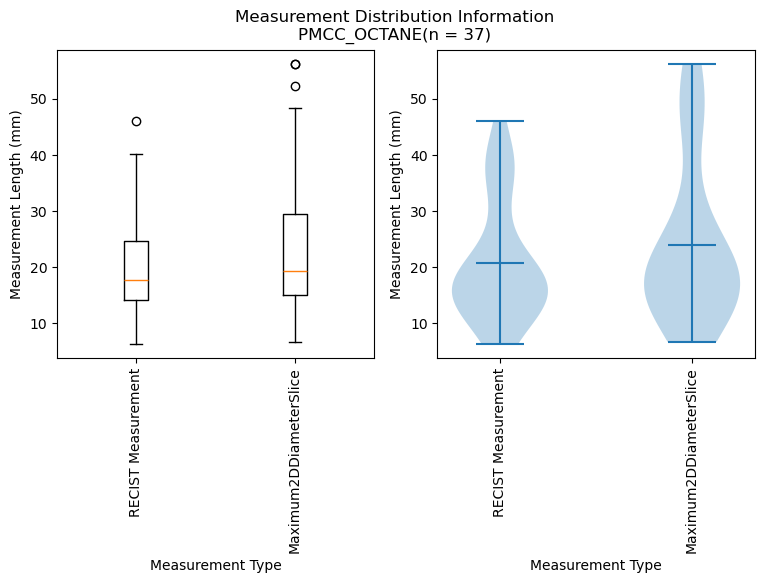

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (9, 4))

#Box plot
ax[0].boxplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]])
ax[0].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[0].set_ylabel("Measurement Length (mm)")
ax[0].set_xlabel("Measurement Type")

#Violin plot 
ax[1].violinplot(pyrad_ann_df[["AnnLongAxisLength", pyrad_feature]],
                 showmeans=True, 
                 showmedians=False)
ax[1].set_xticks([1, 2],["RECIST Measurement", pyrad_feat_label], rotation = 90)
ax[1].set_ylabel("Measurement Length (mm)")
ax[1].set_xlabel("Measurement Type")
fig.suptitle("Measurement Distribution Information\n" + dataset + "(n = " + str(num_ann) + ")")
fig.savefig(save_folder / "Measurement_Distribution_Box_Violin.png", bbox_inches = 'tight') #Makes sure x axis doesn't get cut off

### Scatter Plot Comparison of RECIST Measurements and Pyradiomics Measurements

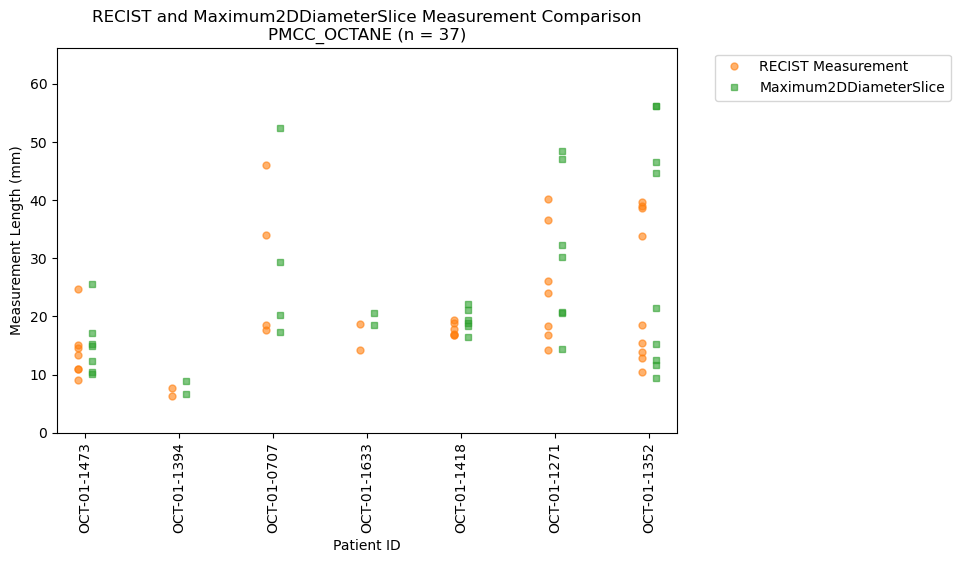

In [99]:
import matplotlib.transforms as transforms

fig, ax = plt.subplots(figsize=(8, 5))

#This is to get the scatter points to appear beside each other. Have to plot temporary points for this to work for some reason
offset = lambda p: transforms.ScaledTranslation(p / 72., 0, plt.gcf().dpi_scale_trans)
temp_points = ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], ms = 10, ls = " ", marker = ".")
for pnt in temp_points:
    pnt.remove()

#Plot the data of interest
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df["AnnLongAxisLength"], 
            ms = 5, 
            marker = "o", 
            ls = " ", #Makes sure there are no lines connecting the dots
            transform=ax.transData + offset(-5),
            alpha = 0.6,
            label = "RECIST Measurement")
ax.plot(pyrad_ann_df["PatientID"], pyrad_ann_df[pyrad_feature], 
            ms = 5, 
            marker = "s", 
            ls = " ",
            transform=ax.transData + offset(5),
            alpha = 0.6,
            label = pyrad_feat_label)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#Adjust the y axis limits in case there are some pyradiomics measurements that are much larger than the annotation length
plt.ylim((0, max(pyrad_ann_df["AnnLongAxisLength"].values.tolist() + pyrad_ann_df[pyrad_feature].values.tolist()) + 10))
plt.xticks(rotation = 90)
plt.xlabel("Patient ID")
plt.ylabel("Measurement Length (mm)")
plt.title("RECIST and " + pyrad_feat_label + " Measurement Comparison\nPMCC_OCTANE (n = " + str(num_ann) + ")")
plt.savefig(save_folder / "RECIST_vs_PyRad_Measure_Compare.png", bbox_inches = 'tight')

### Differences in RECIST Measurement vs. Pyradiomics Measurement

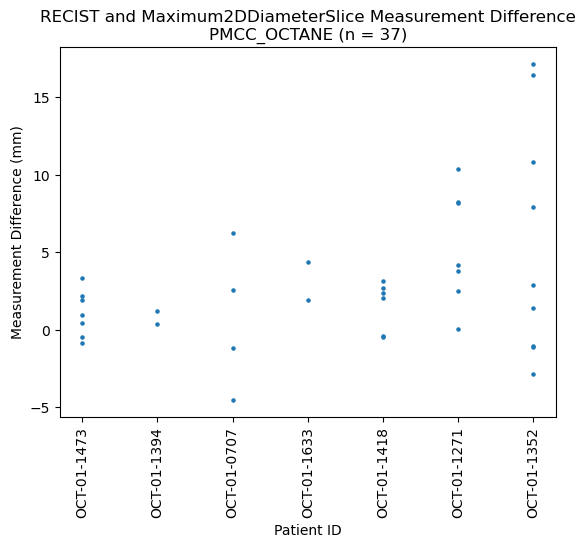

In [100]:
pyrad_ann_df["MeasurementDiff"] = pyrad_ann_df[pyrad_feature] - pyrad_ann_df["AnnLongAxisLength"]

plt.scatter(pyrad_ann_df["PatientID"], pyrad_ann_df["MeasurementDiff"], s=5)
plt.xticks(rotation = 90)
plt.title("RECIST and " + pyrad_feat_label + " Measurement Difference\nPMCC_OCTANE (n = " + str(num_ann) + ")")
plt.ylabel("Measurement Difference (mm)")
plt.xlabel("Patient ID")
plt.savefig(save_folder / "RECIST_PyRad_Measurement_Difference.png", bbox_inches = 'tight')